<a href="https://colab.research.google.com/github/lorenzosintini/4YP/blob/master/Models_v1/Conv_VAE_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import Libraries

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys
from IPython.display import clear_output
import os
tf.autograph.set_verbosity(0)

TensorFlow 2.x selected.


#### Import Data and plot it

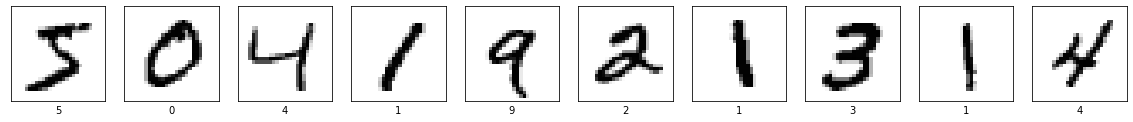

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

class_names = ['Zero','One', 'Two', 'Three', 'Four', 'Five','Six', 'Seven', 'Eight', 'Nine']
N_image_channels = 1
N_class = len(class_names)
image_shape = x_train.shape[1:3]
input_range = np.amax(x_train)

def plot_images(x_train, y_train, figures_to_plot, pick_random=False, include_labels=True):
    n_rows = np.ceil((figures_to_plot[1])/10)
    plot = plt.figure(figsize=[20,2*n_rows])
    for i in range(figures_to_plot[0],figures_to_plot[1]):
        if pick_random: 
            pic_n = random.randint(0,len(x_train))
        else: pic_n = i
        plt.subplot(n_rows,10,i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(x_train[pic_n], cmap=plt.cm.binary)
        if include_labels:
            plt.xlabel(y_train[pic_n])
    plt.show()

plot_images(x_train, y_train, [0,10])

#### Select data, pre-process it and create dataset

In [0]:
def pick_class(x, y, class_n):
    pics = (y == class_n[0])
    for i in range(len(class_n)-1):
      pics = pics + (y == class_n[i+1])
    new_x = x[pics]
    new_y = y[pics]
    return new_x, new_y

def set_pixels_binary(images):
    images = images/input_range
    return images

def make_categorical(y):
    y_cat = tf.keras.utils.to_categorical(y)
    return y_cat

def cut_data(data, data_number):
    data = data[0:data_number]
    return data

def setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7,8,9], data_number = -1):
  x_train, y_train = pick_class(x_train, y_train, chosen_classes)
  x_test, y_test = pick_class(x_test, y_test, chosen_classes)
  
  x_train = cut_data(x_train, data_number)
  y_train = cut_data(y_train, data_number)

  x_train = set_pixels_binary(x_train)
  x_test = set_pixels_binary(x_test)

  x_train = x_train.reshape(len(y_train), image_shape[0], image_shape[1], N_image_channels).astype('float32')
  x_test = x_test.reshape(len(y_test), image_shape[0], image_shape[1], N_image_channels).astype('float32')

  batch_size = 100
  train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(len(y_train)).batch(batch_size)
  test_dataset = tf.data.Dataset.from_tensor_slices(x_test).shuffle(len(y_test)).batch(batch_size)
  return x_train, y_train, x_test, y_test, train_dataset, test_dataset

#### Create Variational Autoencoder (VAE) Model

In [0]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(500, activation='relu', input_shape=(28, 28, 1)),
                          tf.keras.layers.Dense(300, activation='relu'),
                          tf.keras.layers.Dense(z_size*2)
                          #tf.keras.layers.Conv2D(32, (3,3), strides = (2,2), activation='relu', input_shape=(28, 28, 1)),
                          #tf.keras.layers.Conv2D(64, (3,3), strides = (2,2), activation='relu'),
                          #tf.keras.layers.Flatten(),
                          #tf.keras.layers.Dense(z_size*2)
                          ])

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Dense(300, activation='relu', input_shape=(z_size,)),
                          tf.keras.layers.Dense(500, activation='relu'),
                          tf.keras.layers.Dense(28*28*1),
                          tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
                          #tf.keras.layers.Dense(units=7*7*64, activation='relu', input_shape=(z_size,)),
                          #tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
                          #tf.keras.layers.Conv2DTranspose(32, (3,3), strides = (2,2), activation='relu', padding='SAME'),
                          #tf.keras.layers.Conv2DTranspose(1, (3,3), strides = (2,2), padding='SAME'),
                          ])

    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled
      

    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        return pixel_output

#### Define the loss function 

In [0]:
def calculate_ELBO(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  pixel_prob = tf.math.sigmoid(x_logit)

  variance = 0.2**2
  logpx_z = tf.reduce_sum(-.5 * (((x - pixel_prob) ** 2. / variance) + tf.math.log(variance * 2.0 * np.pi)), axis=[1, 2, 3])
  KL = -0.5*(tf.reduce_sum(tf.math.add(logvar,1), axis=1) - tf.reduce_sum(tf.exp(logvar), axis=1) - tf.reduce_sum(tf.exp(mean ** 2), axis=1))

  return -tf.reduce_mean(logpx_z - KL)

#### Define the optimizer

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

#### Define loss metrics

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

#### Define train and test steps

In [0]:
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_ELBO(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, optimizer):
    loss = calculate_ELBO(model, x)
    test_loss(loss)

#### Generate random image from latent vector

In [0]:
def generate_images(model, z_random, figures_to_plot):
    generated_prob = model.decode(z_random)
    generated_prob = tf.math.sigmoid(generated_prob)
    generated_prob = np.squeeze(generated_prob, axis=3)
    plot_images(generated_prob, _, figures_to_plot, include_labels=False)

In [0]:
def train_test_dataset(model, train_dataset, test_dataset, epochs, generate=True):
  plots_per_epoch = 10
  z_random = tf.random.normal(shape=[plots_per_epoch, z_size])
  
  test_ELBO = []
  train_ELBO = []
  epoch_number = []  
  for epoch in range(epochs):
    print('Epoch {}'.format(epoch))
    for train_x in train_dataset: 
      train_step(model, train_x, optimizer)
  
    for test_x in test_dataset:
      test_step(model, test_x, optimizer)
    
    test_ELBO.append(-test_loss.result())
    train_ELBO.append(-train_loss.result())
    epoch_number.append(epoch)
    
    clear_output()
    if generate:
      generate_images(model, z_random, [0,plots_per_epoch])
    plt.plot(epoch_number, test_ELBO, train_ELBO)
    plt.legend(['test','train'])
    plt.title('model')
    plt.show()
  train_loss.reset_states()
  test_loss.reset_states()

#### Train the data

In [0]:
def change_ratio(x, y, chosen_classes, chosen_numbers):
    x_new = np.zeros([0,image_shape[0], image_shape[1]])
    y_new = np.zeros([0])
    n_classes = len(chosen_classes)
    for i in range (n_classes):
        if chosen_classes[i] != -1:
            x_class, y_class = pick_class(x, y, [chosen_classes[i]])
            x_class = cut_data(x_class, chosen_numbers[i])
        y_class = cut_data(y_class, chosen_numbers[i])
        x_new = np.concatenate((x_new, x_class))
        y_new = np.concatenate((y_new, y_class))
    return x_new, y_new

In [0]:
chosen_classes=[0,1,2,3,4,5,6,7,8,9]
chosen_numbers = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
x_train, y_train = change_ratio(x_train, y_train, chosen_classes, chosen_numbers)
chosen_numbers = [850, 850, 850, 850, 850, 850, 850, 850, 850, 850]
x_test, y_test = change_ratio(x_test, y_test, chosen_classes, chosen_numbers)

x_train_0, y_train_0, x_test_0, y_test_0, train_dataset_0, test_dataset_0 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0])
x_train_1, y_train_1, x_test_1, y_test_1, train_dataset_1, test_dataset_1 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[1])
x_train_2, y_train_2, x_test_2, y_test_2, train_dataset_2, test_dataset_2 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[2])
x_train_3, y_train_3, x_test_3, y_test_3, train_dataset_3, test_dataset_3 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[3])
x_train_4, y_train_4, x_test_4, y_test_4, train_dataset_4, test_dataset_4 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[4])
x_train_5, y_train_5, x_test_5, y_test_5, train_dataset_5, test_dataset_5 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[5])
x_train_6, y_train_6, x_test_6, y_test_6, train_dataset_6, test_dataset_6 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[6])
x_train_7, y_train_7, x_test_7, y_test_7, train_dataset_7, test_dataset_7 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[7])
x_train_8, y_train_8, x_test_8, y_test_8, train_dataset_8, test_dataset_8 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[8])
x_train_9, y_train_9, x_test_9, y_test_9, train_dataset_9, test_dataset_9 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[9])

z_size = 10
model_0 = CVAE(z_size)
model_1 = CVAE(z_size)
model_2 = CVAE(z_size)
model_3 = CVAE(z_size)
model_4 = CVAE(z_size)
model_5 = CVAE(z_size)
model_6 = CVAE(z_size)
model_7 = CVAE(z_size)
model_8 = CVAE(z_size)
model_9 = CVAE(z_size)

model_dict = {'0' : model_0,
              '1' : model_1,
		          '2' : model_2,
              '3' : model_3,
              '4' : model_4,
              '5' : model_5,
              '6' : model_6,
              '7' : model_7,
              '8' : model_8,
              '9' : model_9,}

train_test_dataset(model_0, train_dataset_0, test_dataset_0, 25, generate=True)
train_test_dataset(model_1, train_dataset_1, test_dataset_1, 25, generate=True)
train_test_dataset(model_2, train_dataset_2, test_dataset_2, 25, generate=True)
train_test_dataset(model_3, train_dataset_3, test_dataset_3, 25, generate=True)
train_test_dataset(model_4, train_dataset_4, test_dataset_4, 25, generate=True)
train_test_dataset(model_5, train_dataset_5, test_dataset_5, 25, generate=True)
train_test_dataset(model_6, train_dataset_6, test_dataset_6, 25, generate=True)
train_test_dataset(model_7, train_dataset_7, test_dataset_7, 25, generate=True)
train_test_dataset(model_8, train_dataset_8, test_dataset_8, 25, generate=True)
train_test_dataset(model_9, train_dataset_9, test_dataset_9, 25, generate=True)

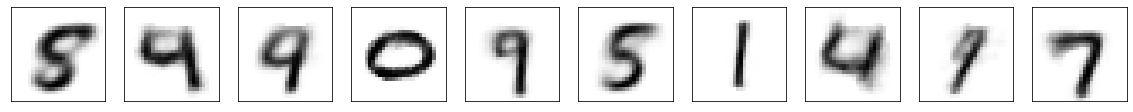

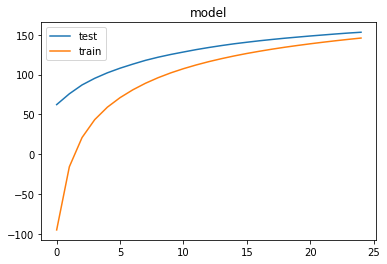

In [19]:
train_images, train_labels, test_images, test_labels, train_dataset, test_dataset = setup_dataset(x_train, y_train, x_test, y_test)
z_size = 2
model = CVAE(z_size)
train_test_dataset(model, train_dataset, test_dataset, 25, generate=True)

#### Reconstruct images

Original Pictures:


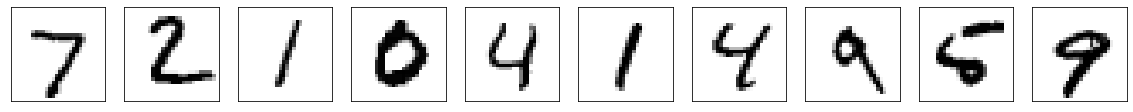

Reconstructed Pictures with VAE:


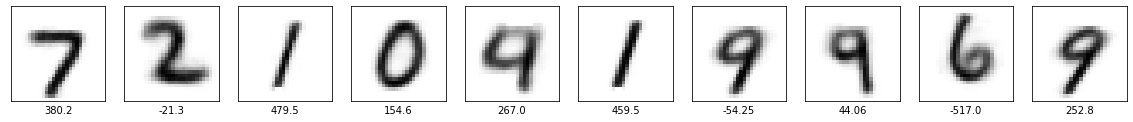

In [21]:
def reconstruct_images(model, images):
    images_n = len(images)
    x = images

    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_output = model.decode(z)
    pixel_prob = tf.math.sigmoid(pixel_output)
    pixel_prob = np.squeeze(pixel_prob, axis=3)

    loss = np.empty([images_n])
    for i in range(images_n):
        loss[i] = calculate_ELBO(model,x[i:i+1])
    loss = loss.astype('float16')
    
    print('Original Pictures:')
    plot_images(images[:,:,:,0], _, figures_to_plot=[0,images_n], include_labels=False)
    print('Reconstructed Pictures with VAE:')
    plot_images(pixel_prob, -loss, figures_to_plot=[0,images_n], include_labels=True)

reconstruct_images(model, test_images[0:10])

#### Visualize the latent space

0 Outliers detected


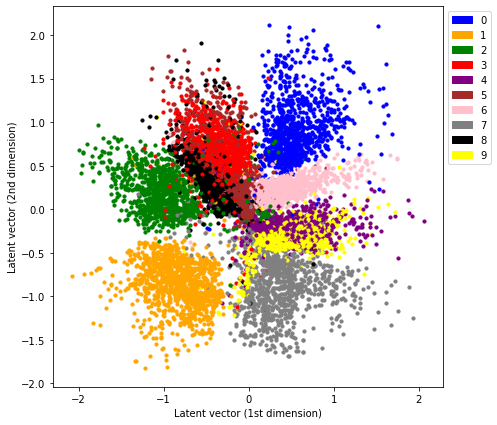

In [23]:
import matplotlib.patches as mpatches
def visualize_latent_space(model, range1, range2, data_x, data_y, a, b):
  plot = plt.figure(figsize=[7,7])
  outliers=0
  for i in range(range1, range2):
    pic_visualize = data_x[i]
    pic_visualize = pic_visualize.reshape(1, 28, 28, 1).astype('float32')
    label_visualize = np.zeros([10,])
    label_visualize[data_y[i]] = 1
    label_visualize = label_visualize.reshape(1, len(label_visualize))
    
    z_mean, z_logvar = model.encode(pic_visualize)
    z = model.reparameterize(z_mean, z_logvar)
    num=np.argmax(label_visualize)

    if num == 0:
      color = 'blue'
    if num == 1:
      color = 'orange'
    if num == 2:
      color = 'green'
    if num == 3:
      color = 'red'
    if num == 4:
      color = 'purple'  
    if num == 5:
      color = 'brown'
    if num == 6:
      color = 'pink'
    if num == 7:
      color = 'gray'
    if num == 8:
      color = 'black'
    if num == 9:
      color = 'yellow'
    plt.scatter(z[:,a],z[:,b], color=color, s=10)
  #plt.axis([-900, 900, -900, 900])
  plt.xlabel('Latent vector (1st dimension)')
  plt.ylabel('Latent vector (2nd dimension)')
  blue = mpatches.Patch(color = 'blue', label='0')
  orange = mpatches.Patch(color = 'orange', label='1')
  green = mpatches.Patch(color = 'green', label='2')
  red = mpatches.Patch(color = 'red', label='3')
  purple = mpatches.Patch(color = 'purple', label='4')
  brown = mpatches.Patch(color = 'brown', label='5')
  pink = mpatches.Patch(color = 'pink', label='6')
  gray = mpatches.Patch(color = 'gray', label='7')
  black = mpatches.Patch(color = 'black', label='8')
  yellow = mpatches.Patch(color = 'yellow', label='9')
  plt.legend(handles=[blue, orange, green, red, purple, brown, pink, gray, black, yellow], bbox_to_anchor=(1,1), loc='upper left')
  print('{} Outliers detected'.format(outliers))

visualize_latent_space(model, 0,10000, test_images, test_labels, 0,1)

#### Check reconstruction performance for untrained classes


Model trained with class 0


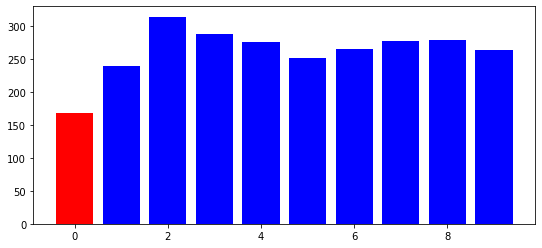

Model trained with class 1


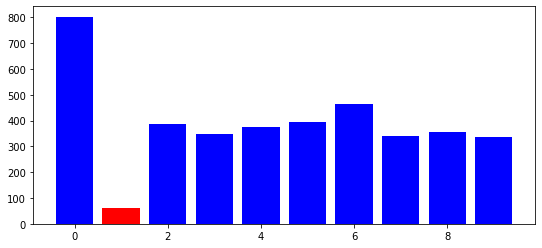

Model trained with class 2


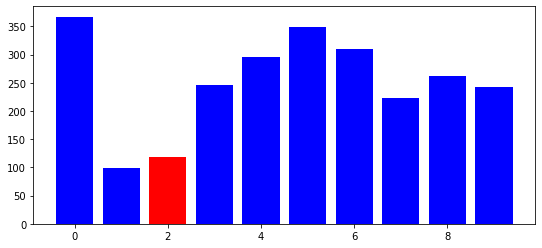

Model trained with class 3


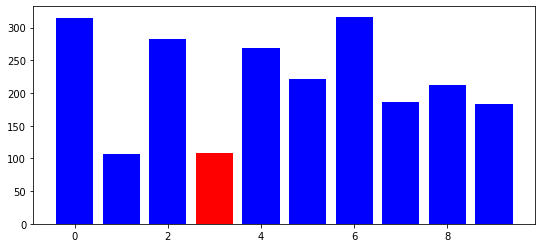

Model trained with class 4


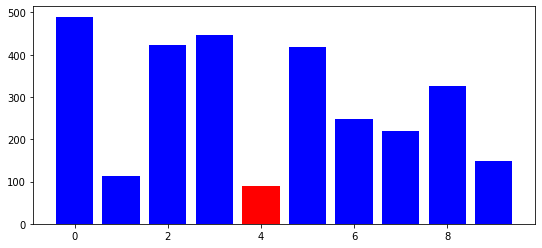

Model trained with class 5


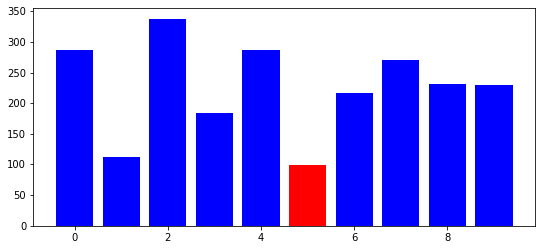

Model trained with class 6


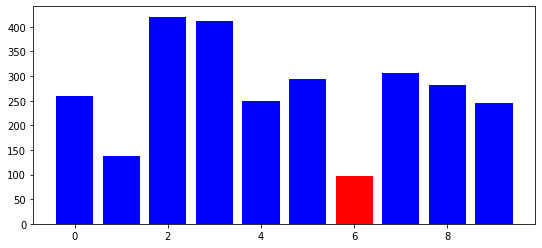

Model trained with class 7


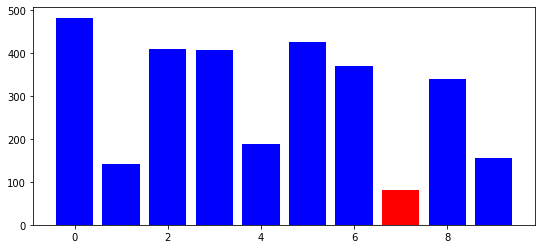

Model trained with class 8


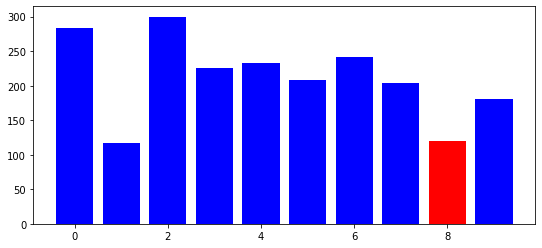

Model trained with class 9


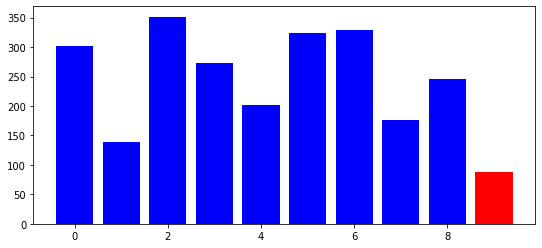

In [0]:
table_of_losses = np.zeros([N_class, N_class])
for i in range(0,N_class):
  model = model_dict[str(i)]
  print('Model trained with class {}'.format(i))
  plt.figure(figsize=[9,4])
  for j in range(N_class):
    test_images = x_test[(y_test==j)]
    test_images = set_pixels_binary(test_images)
    test_images = test_images.reshape(len(test_images), image_shape[0], image_shape[1], N_image_channels).astype('float32')
    loss = -calculate_ELBO(model,test_images)
    table_of_losses[j,i] = -loss
    if j==i:
      color='red'
    else:
      color='blue'
    plt.bar(j,-loss.numpy(),color=color)
    #print('ELBO loss for class {}: {}'.format(i,loss))
  plt.show()
  

# reconstruct_images(x_test[(y_test==8)][0:10], test_images[(y_test==8)][0:10])

#visualize_latent_space(0,1000, x_train, y_train, 0,1)
#classes_to_pick = [1]
#x_reconstruct_test, y_reconstruct_test = pick_class(x_test, y_test, classes_to_pick)
#visualize_latent_space(0,100, x_reconstruct_test, y_reconstruct_test, 0,1)


#### Classify test images

In [0]:
_, _, x_test_classes, y_test_classes, _, _ = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7,8,9])
predicted_class = np.zeros([1,len(x_test_classes)])
for i in range(len(x_test_classes)):
  if not i%50:
    clear_output()
    print('Progress:{}%'.format(100*(i+1)/len(x_test_classes)))
  test_image = x_test_classes[i]/input_range
  test_image[test_image >= 0.5] = 1.0
  test_image[test_image < 0.5] = 0.0
  test_image = test_image.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
  
  loss_per_model = []
  for j in range(0,10):
    model = model_dict[str(j)]
    loss = -calculate_ELBO(model,test_image)
    #print('ELBO loss for class {}: {}'.format(i,loss))
    loss_per_model.append(loss)
  predicted_class[0,i] = loss_per_model.index(max(loss_per_model))
print(predicted_class)

Progress:99.4235294117647%
[[0. 0. 0. ... 9. 9. 9.]]


#### Check accuracy and plot misslabeled images

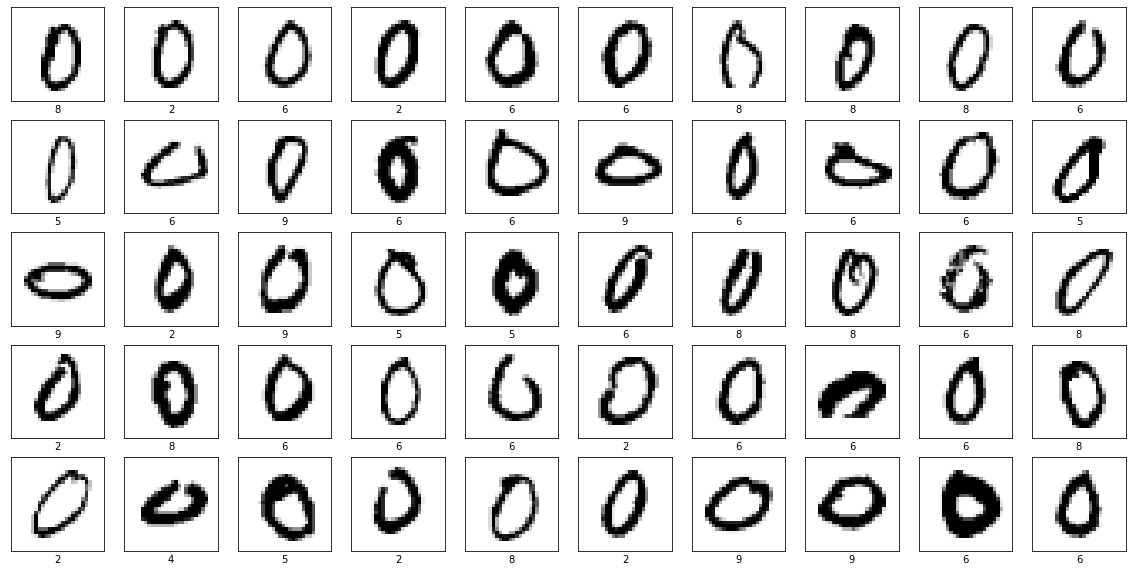

In [0]:
import pandas as pd
predicted_class = predicted_class.astype('int')
y_test_classes = y_test_classes.astype('int')

wrong_guesses = []
table_of_counts = np.zeros([N_class, N_class+1])
for i in range(predicted_class.shape[1]):
    table_of_counts[y_test_classes[i], predicted_class[0,i]]+=1
    if y_test_classes[i] != predicted_class[0,i]:
        wrong_guesses.append(i)
trace_count = table_of_counts.trace().astype('int')
sum_count = table_of_counts.sum().astype('int')
for i in range(N_class):
    accuracy_of_class = 100*table_of_counts[i,i]/np.sum(table_of_counts[i,0:-1])
    table_of_counts[i,-1] = accuracy_of_class.astype('float16')

index = list(str('-') * N_class)
columns = list(str('-') * (N_class+1))
for i in range(N_class):
    index[i]= 'Class '+ str(i)
    columns[i] = '|' + str(i) + '_Counts|'
columns[-1] = 'Percentage'
table = pd.DataFrame.from_records(table_of_counts, index=index, columns=columns)

pics_to_plot = list(x_test[i] for i in wrong_guesses)
labels = list(predicted_class[0,i] for i in wrong_guesses)
plot_images(pics_to_plot[0:50], labels[0:50], [0,len(labels[0:50])])

In [0]:
print('Correctly labelled pictures:{}/{} -> Accuracy: {}%'.format(trace_count, sum_count, trace_count/sum_count*100))
print('Incorrectly labelled pictures:{}/{} -> Error: {}%'.format(sum_count-trace_count, sum_count, (sum_count-trace_count)/sum_count*100))
table

Correctly labelled pictures:7879/8500 -> Accuracy: 92.69411764705883%
Incorrectly labelled pictures:621/8500 -> Error: 7.305882352941176%


,|0_Counts|,|1_Counts|,|2_Counts|,|3_Counts|,|4_Counts|,|5_Counts|,|6_Counts|,|7_Counts|,|8_Counts|,|9_Counts|,Percentage
Class 0,625.0,0.0,29.0,1.0,7.0,36.0,82.0,1.0,39.0,30.0,73.5000
Class 1,0.0,774.0,26.0,7.0,4.0,5.0,1.0,8.0,24.0,1.0,91.0625
Class 2,2.0,2.0,823.0,2.0,4.0,2.0,0.0,6.0,9.0,0.0,96.8125
Class 3,0.0,0.0,8.0,807.0,0.0,29.0,0.0,2.0,4.0,0.0,94.9375
Class 4,0.0,0.0,2.0,1.0,832.0,1.0,1.0,6.0,4.0,3.0,97.8750
Class 5,1.0,1.0,0.0,9.0,0.0,832.0,0.0,1.0,6.0,0.0,97.8750
Class 6,1.0,1.0,2.0,1.0,9.0,16.0,815.0,0.0,5.0,0.0,95.8750
Class 7,0.0,1.0,16.0,8.0,8.0,1.0,0.0,794.0,6.0,16.0,93.4375
Class 8,0.0,0.0,10.0,20.0,1.0,18.0,2.0,1.0,793.0,5.0,93.3125
Class 9,0.0,2.0,2.0,12.0,18.0,14.0,0.0,8.0,10.0,784.0,92.2500


In [0]:
# Convolutional VAE for each class results in accuracy of 98.16% with z_size = 10
# Convolutional VAE for each class results in accuracy of 89.90% with z_size = 2

In [0]:
index = list(str('-') * N_class)
columns = list(str('-') * (N_class))
for i in range(N_class):
    index[i]= 'Class '+ str(i)
    columns[i] = 'Model ' + str(i)

table_loss = pd.DataFrame.from_records(np.around(table_of_losses, decimals=2), index=index, columns=columns)
table_loss

,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8,Model 9
Class 0,168.17,802.06,367.00,314.68,489.92,286.36,260.13,483.06,283.80,301.82
Class 1,239.28,59.54,98.66,106.70,112.78,112.99,137.17,141.25,117.05,139.61
Class 2,314.27,387.83,117.56,283.24,422.94,337.73,420.55,410.88,299.86,351.52
Class 3,288.80,349.47,245.93,107.65,446.45,183.61,412.06,407.45,224.98,272.88
Class 4,276.05,375.01,295.73,268.60,90.56,286.31,248.51,189.14,232.31,202.27
Class 5,251.19,394.49,349.01,220.95,419.27,99.46,293.61,427.50,208.78,323.19
Class 6,265.31,463.02,309.43,316.59,249.04,216.06,97.07,370.19,241.54,329.76
Class 7,277.72,340.95,222.70,186.96,218.66,270.89,305.29,81.05,204.18,176.81
Class 8,279.19,357.07,261.93,211.69,325.20,230.76,281.67,341.18,120.13,245.27
Class 9,264.34,335.53,242.50,182.48,148.91,230.24,245.38,155.78,180.88,87.22
